In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import umap
%matplotlib inline
sns.set(style='white', rc={'figure.figsize':(12,8)})

import requests
import tarfile
import imageio
import glob

### Pull the data from the internet and write it to a file then unpack the file to disk.

Don't bother running this if you've already downloaded the dataset. 

We are unpacking the file into the directory that the notebook is running in.  Don't worry the coil-100 dataset should only take a few minutes to download on a good connection.

In [11]:
%%time
getData = True  # Change this to false the first time you run the notebook
if(getData): 
    results = requests.get('http://www.cs.columbia.edu/CAVE/databases/SLAM_coil-20_coil-100/coil-100/coil-100.tar.gz')
    with open("coil_100.tar.gz", "wb") as code:
        code.write(results.content)

    images_zip = tarfile.open('coil_100.tar.gz', mode='r:gz')
    images_zip.extractall()

CPU times: user 19.3 s, sys: 5.57 s, total: 24.9 s
Wall time: 1min 41s


### Read our images from disk via the wonders of imageio.

They are read in as 128x128x3 ndarrays.  We make use of flatten to collapse them down to  a list of 7202, 49152 dimensional vectors.

In [5]:
%%time
feature_vectors = []
filelist = glob.glob('./coil-100/*.ppm')
for filename in filelist:
    im = imageio.imread(filename)
    feature_vectors.append(im.flatten())

CPU times: user 26.2 s, sys: 1.38 s, total: 27.6 s
Wall time: 28.1 s


### Now we have our data in a list of vectors.  Let's extract the object id's from the files and cast to data frame (in case we want to explore things further)

In [6]:
labels = pd.Series(filelist).str.extract("obj([0-9]+)", expand=False)

### The pandas data frame here would be too expensive both in time and memory to construct

In [16]:
%%time
data = np.vstack(feature_vectors)
print(data.shape)

(7200, 49152)
CPU times: user 563 ms, sys: 1.88 s, total: 2.44 s
Wall time: 3.24 s


### Now let's use UMAP to embed these points into a two dimensional space.

A little parameter tweaking is required here in order find a particularly attractive embedding of our space.

In [26]:
fit = umap.UMAP(n_neighbors=10, random_state=42, metric='euclidean')
%time u = fit.fit_transform(data)


CPU times: user 3min 56s, sys: 7.79 s, total: 4min 4s
Wall time: 4min 15s


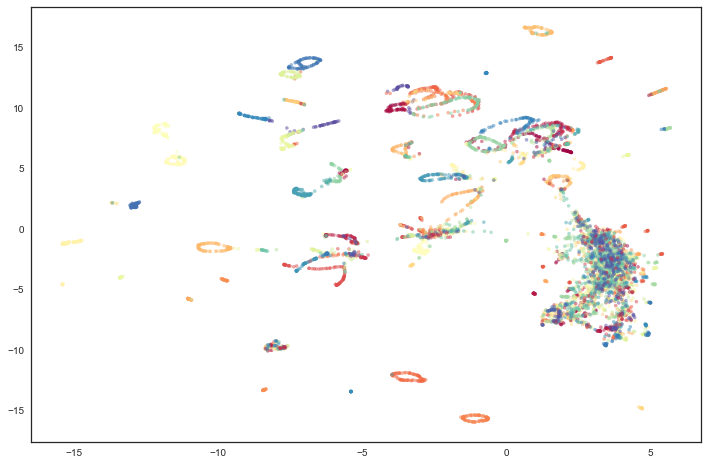

In [29]:
plt.scatter(u[:,0], u[:,1], c=labels, cmap="Spectral", s=10, alpha=0.5)

We see that are are able to preserve a number of the high dimensional structures within this data set.  

### Now we need to run t-SNE and LargeVis on our data

In [23]:
import sklearn.manifold
sklearn.__version__

'0.19.0'

In [24]:
fit_tsne = sklearn.manifold.TSNE()
%time u_tsne = fit_tsne.fit_transform(data)

CPU times: user 1h 32s, sys: 1min 11s, total: 1h 1min 44s
Wall time: 1h 3min 46s


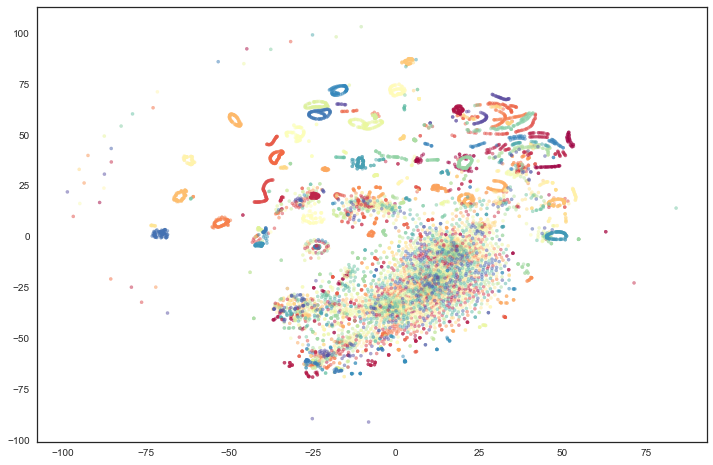

In [28]:
plt.scatter(u_tsne[:,0], u_tsne[:,1], c=labels, cmap="Spectral", s=10, alpha=0.5)